#Requirements

In [0]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

In [0]:
# Required packages 
import numpy as np, itertools, copy
import pandas as pd
import math
import random
from collections import namedtuple, defaultdict
import pickle
from google.colab import files

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.style
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import networkx as nx
from scipy.spatial.distance import squareform, pdist
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap as Basemap


#Objects

We have 5 classes - Passenger, Vehicle, Trip, Action, State.

This being used for the implementation of our problem.


In [0]:
ON_TRIP = 'ON_TRIP'

class Passenger:
    class_counter = 0
    
    def __init__(self,id,origin, destination): # Constructor to initialize the object
        self.id = id
        Passenger.class_counter = Passenger.class_counter +  1
        self.origin = origin
        self.location = origin
        self.destination = destination

    def is_satisfied(self):  # Check whether the current location and destination are same
        if self.location == self.destination:
          return 1
        else:
          return 0
    
    def __str__(self): # Return string
        return ' Passenger: ' + str(self.id) + ' Origin: ' + str(self.origin) + ' Location: ' + str(self.location) +' Destination: ' + str(self.destination)

    def __eq__(self, other): # This function is similar to equal, where it compares self object with other object
        if not (hasattr(other, 'id') and self.id == other.id):
            return False
        else:
            if self.location == other.location and self.destination == other.destination:
              return True
            else:
              return False

    def __hash__(self): # Hash function to hash the object parameters
        hash_val = hash(self.id)
        hash_val += hash(self.location)
        hash_val += hash(self.destination)
        return hash_val

class Vehicle:
    class_counter = 0

    def __init__(self, id,origin, seats):
        self.id = id
        Vehicle.class_counter += 1
        self.origin = origin
        self.location = origin
        self.seats = seats

    def __str__(self):
        return ' Vehicle Number: ' + str(self.id) + ' Location: ' + str(self.location)

    def __eq__(self, other):
        if not (hasattr(other, 'id') and self.id == other.id):
            return False
        else:
            if other.location == self.location:
              return True
            else:
              return False

    def __hash__(self):
        hash_val = hash(self.id)
        hash_val += hash(self.location)
        return hash_val


class Trip:
    def __init__(self, vehicle, origin, destination, passengers, state):
        self.vehicle = vehicle
        self.origin = origin
        self.destination = destination
        self.passengers = passengers
        self.original_distance = state.city_distance(origin, destination)
        self.remaining_distance = self.original_distance

    def has_vehicle(self, vehicle):  # Check for existence of vehicle
        if self.vehicle.id == vehicle.id:
          return True
        else:
          return False

    def has_passenger(self, passenger): #Check for passenger
        for passengers in self.passengers:
            if passengers.id == passenger.id:
                return True
        return False

    def get_cost(self): # Returns the distance of 2 places 
        return self.original_distance

    def __str__(self):
        string = 'Vehicle Number: ' + str(self.vehicle.id) + ' : ' + str(self.origin) + ' -> ' + str(self.destination) + ' Passenger : '
        for passenger in self.passengers:
            string += str(passenger.id) + ' , '
        return string

    def __eq__(self, other):
      return other.vehicle == self.vehicle and other.origin == self.origin and other.destination == self.destination and other.passengers == self.passengers

    def __hash__(self):
        hash_val = hash(self.vehicle)
        hash_val += hash(self.origin)
        hash_val += hash(self.destination)
        for passenger in self.passengers:
            hash_val += hash(passenger)

        return hash_val

class Action: # Action to be taken by the agent 
    def __init__(self, trips):
        self.trips = []
        self.add_trips(trips)

    def add_trips(self, trips): # To increase the number of trips
        for trip in trips:
            for a in trip:
                self.trips.append(a)

    def get_cost(self):
        cost = 0
        for f in self.trips:
            cost += f.get_cost()
        return cost
        
    def __str__(self):
        print('Action taken: ')
        for each_trip in self.trips:
            print(each_trip)
        return ''

    def __eq__(self, other):
        if set(self.trips) == set(other.trips):
          return True
        else:
          return False

    def __hash__(self):
        hash_val = 0
        for trip in self.trips:
            hash_val += hash(trip)

        return hash_val


class State:  # The state of the agent

    def __init__(self, cities, passengers, vehicles, distances=None):
        self.cities = cities
        self.vehicles = vehicles
        self.passengers = passengers
        self.ongoing_trips = []
        if distances is None:
            self.city_distances = np.ones((len(cities), len(cities))) - np.eye(len(cities))
        else:
            self.city_distances = distances

    def city_distance(self, a, b):
        return self.city_distances[self.cities.index(a)][self.cities.index(b)]

    def vehicles_where_passengers(self):
        passengers = copy.deepcopy(self.passengers)
        score = 0
        for vehicle in self.vehicles:
            vehicle_score = 0
            for passenger in passengers:
                if passenger.location == vehicle.location:
                    if not passenger.is_satisfied():
                        vehicle_score += 1
                        passengers.remove(passenger)

            score += min(vehicle_score, vehicle.seats)

        return score

    def satisfied_passengers(self):
        satisfied_passengers = 0
        for passenger in self.passengers:
            if passenger.is_satisfied():
                satisfied_passengers += 1

        return satisfied_passengers

    def __valid_combination(self, combination, vehicles_in_city):
        for vehicle in vehicles_in_city:
            if combination.count(vehicle.id) > vehicle.seats:
                return False

        return True

    def __group_passengers(self, passengers_in_city, combination, vehicle_ids):
        n_cities = len(self.cities)
        groupings = {}
        if sum(1 for i in combination if i != -1) == 0:
            return ''
        else:
            for vehicle_idx in vehicle_ids:
                if vehicle_idx != -1:
                    groupings[vehicle_idx] = np.zeros(n_cities)

            for passenger_idx, vehicle_idx in enumerate(combination):
                if vehicle_idx != -1:
                    destIdx = self.cities.index(passengers_in_city[passenger_idx].destination)
                    groupings[vehicle_idx][destIdx] += 1

            res_str = ''
            for vehicle_idx in sorted(groupings):
                if vehicle_idx != -1:
                    res_str += str(int(vehicle_idx))
                    for n in groupings[vehicle_idx]:
                        res_str += str(int(n))

            return res_str

    def get_actions(self):
        if self.satisfied_passengers() == len(self.passengers):
            return []
        else:
            actions = []
            for city in self.cities:
                vehicles_in_city = self._State__get_vehicles_in_city(city)
                if len(vehicles_in_city) == 0:
                    continue
                passengers_in_city = self._State__passengers_in_city(city)
                vehicles_id = [vehicle.id for vehicle in vehicles_in_city]
                vehicles_id.append(-1)
                combinations = list(itertools.product(vehicles_id, repeat=(len(passengers_in_city))))
                seen_groupings = set()
                city_combinations = None
                for combination in combinations:
                    if not self._State__valid_combination(combination, vehicles_in_city):
                        continue
                    combination_trips = []
                    for vehicle in vehicles_in_city:
                        passengers = []
                        for passenger, vehicle_id in zip(passengers_in_city, combination):
                            if vehicle_id == vehicle.id:
                                passengers.append(passenger)

                        vehicle_trips = []
                        for destination in self.cities:
                            if destination != city or destination == city and len(passengers) == 0:
                                vehicle_trips.append(Trip(vehicle, city, destination, passengers, self))

                        combination_trips.append(vehicle_trips)

                    combination_trips = list((itertools.product)(*combination_trips))
                    if city_combinations is None:
                        city_combinations = np.array(combination_trips)
                    else:
                        city_combinations = np.concatenate((city_combinations, np.array(combination_trips)))

                actions.append(city_combinations)

            actions = list((itertools.product)(*actions))
            final_actions = []
            for action in actions:
                final_actions.append(Action(action))

            return final_actions

    def apply_action(self, action, missed_vehicle_prob=0.0):
        for trip in self.ongoing_trips:
            trip.remaining_distance -= 1
            if trip.remaining_distance <= 0:
                self.ongoing_trips.remove(trip)
                for passenger in self.passengers:
                    if trip.has_passenger(passenger):
                        passenger.location = np.random.uniform() >= missed_vehicle_prob and trip.destination

                for vehicle in self.vehicles:
                    if trip.has_vehicle(vehicle):
                        vehicle.location = trip.destination

        for trip in action.trips:
            trip.remaining_distance -= 1
            if trip.remaining_distance <= 0:
                for passenger in self.passengers:
                    if trip.has_passenger(passenger):
                        passenger.location = np.random.uniform() >= missed_vehicle_prob and trip.destination

                for vehicle in self.vehicles:
                    if trip.has_vehicle(vehicle):
                        vehicle.location = trip.destination

            else:
                for passenger in self.passengers:
                    if trip.has_passenger(passenger):
                        passenger.location = ON_TRIP

                for vehicle in self.vehicles:
                    if trip.has_vehicle(vehicle):
                        vehicle.location = ON_TRIP

                self.ongoing_trips.append(trip)

    def __passengers_in_city(self, city):
        passengers = []
        for passenger in self.passengers:
            if passenger.location == city:
                if not passenger.is_satisfied():
                    passengers.append(passenger)

        return passengers

    def __get_vehicles_in_city(self, city):
        vehicles = []
        for vehicle in self.vehicles:
            if vehicle.location == city:
                vehicles.append(vehicle)

        return vehicles

    def __str__(self):
        print('------------------------ ------------ ------------------------')
        for city in self.cities:
            print('City ' + str(city) + ':')
            for passenger in self.passengers:
                if passenger.location == city:
                    print(passenger)

            for vehicle in self.vehicles:
                if vehicle.location == city:
                    print(vehicle)

        return '------------------------ ------------ ------------------------'

    def __eq__(self, other):
        if other.vehicles != self.vehicles:
            return False
        elif other.passengers != self.passengers:
            return False
        else:
            return self.cities == other.cities

    def __hash__(self):
        hash_val = 0
        for vehicle in self.vehicles:
            hash_val += hash(vehicle)

        for passenger in self.passengers:
            hash_val += hash(passenger)

        return hash_val


def step(state, action, missed_vehicle_prob=0):
    next_state = copy.deepcopy(state)
    next_state.apply_action(action, missed_vehicle_prob)
    reward = 100 * (next_state.satisfied_passengers() - state.satisfied_passengers())
    reward += 50 * (next_state.vehicles_where_passengers() - state.vehicles_where_passengers())
    reward -= 50
    reward -= action.get_cost()

    done = next_state.satisfied_passengers() == len(next_state.passengers)
    if done:
        reward += 2000
    return (next_state, reward, done)

#Stimulated Data

In [9]:
def stimulated_data():
    cities = ["A", "B", "C", "D"]
    city_distances =   [[0, 6, 2, 3],
                        [1, 0, 2, 2],
                        [5, 3, 0, 2],
                        [4, 5, 2, 0]]
    passengers =   [Passenger(1,"A", "B"),Passenger(2,"B", "D"),Passenger(3,"B", "C"),Passenger(4,"C", "A"),Passenger(5,"C", "B")]
    vehicles = [Vehicle(1,"C", 10),Vehicle(2,"B",5),Vehicle(3,"A",2)]
    time_steps = 1
    return State(cities, passengers, vehicles, city_distances), time_steps, len(passengers)

state, steps,n = stimulated_data()
print("Diplaying Random state and action")
print(state)
actions = state.get_actions()
print(actions[4])

Diplaying Random state and action
------------------------ ------------ ------------------------
City A:
 Passenger: 1 Origin: A Location: A Destination: B
 Vehicle Number: 3 Location: A
City B:
 Passenger: 2 Origin: B Location: B Destination: D
 Passenger: 3 Origin: B Location: B Destination: C
 Vehicle Number: 2 Location: B
City C:
 Passenger: 4 Origin: C Location: C Destination: A
 Passenger: 5 Origin: C Location: C Destination: B
 Vehicle Number: 1 Location: C
City D:
------------------------ ------------ ------------------------
Action taken: 
Vehicle Number: 3 : A -> B Passenger : 1 , 
Vehicle Number: 2 : B -> A Passenger : 2 , 3 , 
Vehicle Number: 1 : C -> B Passenger : 4 , 



#Open Flight Dataset

In [0]:
#Airport data
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",names = airport_col, index_col = 0)

#Routes data
route_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID','Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
routes_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",names = route_cols)
#clean up data, change 'object' type to numeric and drops NaNs
routes_df['Source Airport ID'] = pd.to_numeric(routes_df['Source Airport ID'].astype(str), 'coerce')
routes_df['Dest Airport ID'] = pd.to_numeric(routes_df['Dest Airport ID'].astype(str), 'coerce')
routes_df = routes_df.dropna(subset=["Source Airport ID", "Dest Airport ID"]) 

#Plane data
plane_col = ['Name','IATA', 'ICAO']
plane_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/planes.dat",names = plane_col, index_col = 0)


#visualization

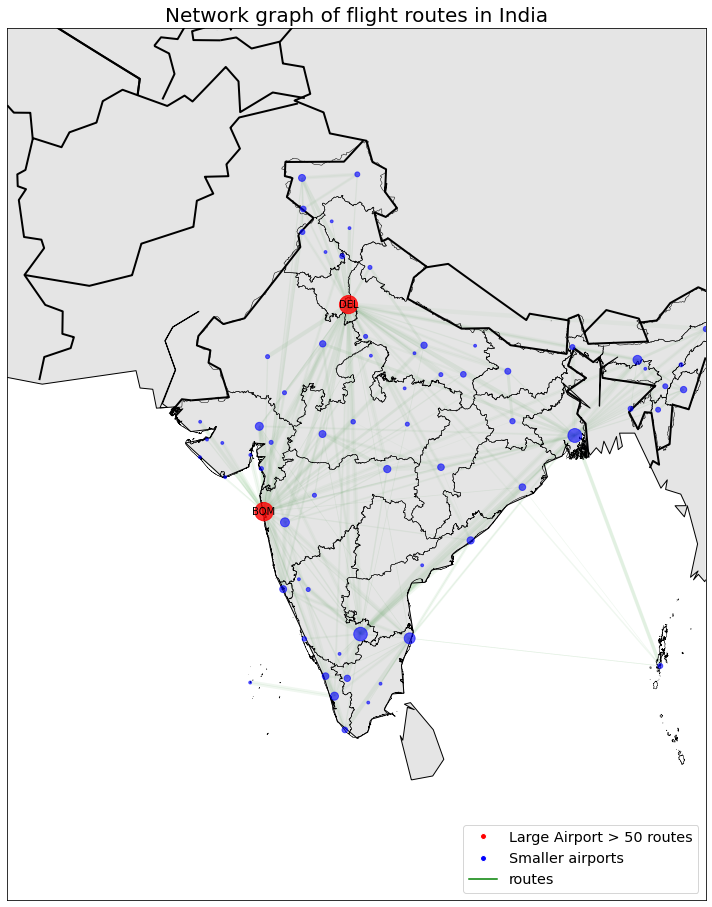

In [13]:
if (airport_df is None) or (routes_df is None):
	print ("Data cannot be Read")
else:
	airport_ind = airport_df[(airport_df.Country == "India")]
	ind_airport_ix = airport_ind.index.values
	routes_ind = routes_df[(routes_df['Source Airport ID'].isin(ind_airport_ix)) &(routes_df['Dest Airport ID'].isin(ind_airport_ix))] 
	routes_ind =  pd.DataFrame(routes_ind.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))
 	
	# to find number of flights in and out of an airport
	counts = routes_ind['Source Airport'].append(routes_ind.loc[routes_ind['Source Airport'] != routes_ind['Dest Airport'], 'Dest Airport']).value_counts()
	counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})
	# create a data frame of position based on names in count
	pos_data = counts.merge(airport_ind, on = 'IATA')
  # create graph
	graph = nx.from_pandas_edgelist(routes_ind, source = 'Source Airport', target = 'Dest Airport',edge_attr = 'counts',create_using = nx.DiGraph())

	# set up base map
	plt.figure(figsize=(10,15))
	m = Basemap(
	        projection='merc',
	        llcrnrlat=0,urcrnrlat=40,llcrnrlon=60,urcrnrlon=95,
	        lat_ts=0,
	        resolution='c')

	m.drawcountries(linewidth = 2)
	m.drawstates(linewidth=3)
	m.drawcoastlines(linewidth=1)
	m.fillcontinents(alpha = 0.5)
	m.readshapefile("IND_adm1",'Watersheds')
    
	# import long lat as m attribute
	mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
	pos = {}
	for count, elem in enumerate (pos_data['IATA']):
	    pos[elem] = (mx[count], my[count])
		 
	# draw nodes and edges and overly on basemap
	nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] >= 50],
	                       node_color = 'r', alpha = 0.8,
	                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] >= 50])

	nx.draw_networkx_labels(G = graph, pos = pos, font_size=10,labels = {x:x for x in graph.nodes() if counts['total_flight'][x] >= 50})

	nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] < 50],
	                       node_color = 'b', alpha = 0.6,
	                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] < 50])

	nx.draw_networkx_edges(G = graph, pos = pos, edge_color = 'g', width = routes_ind['counts']*0.75,alpha=0.06, arrows = False)

	line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
	line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")
	line3 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")
	plt.legend((line1, line2, line3), ('Large Airport > 50 routes', 'Smaller airports', 'routes'),loc=4, fontsize = 'x-large')
	plt.title("Network graph of flight routes in India", fontsize = 20)
	
	#plt.savefig("airline_india.png", format = "png", dpi = 300)	
	#files.download('distance_matric.csv')
	plt.tight_layout()
	plt.show()
 

#getting data

In [29]:
def data():
  airport_india = airport_df[(airport_df.Country == "India") ]
  airport_india.dropna(subset = ['IATA'], inplace=True)
  cities = list(airport_india['IATA'])
  cities = list(filter(lambda a: a != '\\N', cities))
  cities = cities[0:6]

  df = airport_india[['IATA','Lat','Long']]
  distance = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])),columns=df.IATA,index=df.IATA)
  #distance.to_csv('distance_matric.csv')
  #files.download('distance_matric.csv')
  city_distances = distance.values

  passengers=[]
  #n = int(input("Enter the number of person"))  # Number of passengers
  n = 4
  for i in range(n):
    p = random.sample(cities,2)
    while(True):
      if(((routes_df['Source Airport'] == p[0]) & (routes_df['Dest Airport'] == p[1])).any()):
        break
      else:
        p = random.sample(cities,2)
    #print(p,routes_df['Airline'],routes_df['Stops'],distance.loc[p[0],p[1]])    
    passengers.append(Passenger(i+1,p[0],p[1]))
  
  list_vehicles = list(plane_df['IATA'])
  vehicles=[]
  k=0
  for i in range(len(cities)):
    tn = random.randint(0,1)
    for j in range(tn):
      pp = random.sample(list_vehicles,1)
      k = k+1
      vehicles.append(Vehicle(k,cities[i],random.randint(30,50)))
      
  time_steps=1
  return State(cities, passengers, vehicles,city_distances), time_steps,n

state, steps,n = data()
print("Diplaying Random state and action")
print(state)
actions = state.get_actions()
print(actions[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Diplaying Random state and action
------------------------ ------------ ------------------------
City AMD:
 Passenger: 3 Origin: AMD Location: AMD Destination: BOM
 Vehicle Number: 1 Location: AMD
City AKD:
 Vehicle Number: 2 Location: AKD
City IXU:
 Vehicle Number: 3 Location: IXU
City BOM:
 Passenger: 1 Origin: BOM Location: BOM Destination: IXU
 Passenger: 4 Origin: BOM Location: BOM Destination: IXU
 Vehicle Number: 4 Location: BOM
City PAB:
 Vehicle Number: 5 Location: PAB
City BHJ:
 Passenger: 2 Origin: BHJ Location: BHJ Destination: BOM
 Vehicle Number: 6 Location: BHJ
------------------------ ------------ ------------------------
Action taken: 
Vehicle Number: 1 : AMD -> AKD Passenger : 3 , 
Vehicle Number: 2 : AKD -> AMD Passenger : 
Vehicle Number: 3 : IXU -> AMD Passenger : 
Vehicle Number: 4 : BOM -> AMD Passenger : 1 , 4 , 
Vehicle Number: 5 : PAB -> AMD Passenger : 
Vehicle Number: 6 : BHJ -> AMD Passenger : 2 , 



#plotting

In [0]:
# Creddit to: https://github.com/naifmeh/
# Code from: https://github.com/naifmeh/smartbot/blob/master/utils/plotting.py

EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])
BotStats = namedtuple("Bot", ["blocked", "not_blocked"])

def plot_episode_stats(stats, smoothing_window=10, noshow=False, title="None"):
    # Plot the episode reward over time
    fig = plt.figure(figsize=(10, 5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    if title != "None":
        plt.title(title)
    else:
        plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig)
    else:
        plt.show(fig)

    return fig

#Implementation using Q learning

In [0]:
class Quality():
    def __init__(self):
        self.Q = {}

    def update(self, state, action, value): # Update state action pair
        if state not in self.Q:
            self.Q[state] = {}
        self.Q[state][action] = value

    def get(self, state, action):
        if state not in self.Q:
            return 0
        if action not in self.Q[state]:
            return 0
        return self.Q[state][action]
    
    def get_best_action_val(self, state): # Get action having maximum reward
        if state not in self.Q:
            return 0
        return np.argmax(self.Q[state])

    def select_best_action_indx(self, state, actions):
        best_action_indx = 0
        best_action_val = -np.inf
        for idx, action in enumerate(actions):
            val = self.get(state, action)
            if val > best_action_val:
                best_action_val = val
                best_action_indx = idx
        return best_action_indx

    def best_action(self, state):
        if state not in self.Q:
            print("State was never seen before, taking random action")
            return np.random.choice(state.get_actions())
        return max(self.Q[state], key=self.Q[state].get)

class Agent:
    def __init__(self):
        self.Q = Quality()

    def __epsilon_greedy(self, state, epsilon, actions):
        probs = np.ones(len(actions), dtype = float)*epsilon/len(actions)
        best_action_indx = self.Q.select_best_action_indx(state, actions)  
        probs[best_action_indx] += (1.0 - epsilon)
        action_idx = np.random.choice(np.arange(len(probs)), p = probs)
        return actions[action_idx]

    def train(self, initial_state, max_timesteps, num_episodes, alpha, discount, epsilon, miss_trip_prob = 0):
        stats = EpisodeStats(episode_lengths = np.zeros(num_episodes),episode_rewards = np.zeros(num_episodes))
        
        total_actions_num = 0
        total_actions_num_size = 0
        total_iterations = 0
        
        #training  
        for ith_episode in range(num_episodes):
            state = copy.deepcopy(initial_state)
            step_count = 0

            for t in itertools.count():      
                actions = state.get_actions()   # Get all possible actions
                if len(actions) == 0:
                    break
                total_actions_num += len(actions)
                total_actions_num_size += 1
                action = self.__epsilon_greedy(state, epsilon, actions)  
                next_state, reward, done = step(state, action, miss_trip_prob) 
    
                stats.episode_rewards[ith_episode] += reward
                stats.episode_lengths[ith_episode] = t
                
                #updating
                td_target = reward + discount*self.Q.get_best_action_val(next_state)
                old_val = self.Q.get(state, action)
                new_val = old_val + alpha*(td_target - old_val)
                self.Q.update(state, action, new_val)
    
                if done or step_count >= max_timesteps:  # future search is limited 
                    break
                state = next_state
                step_count += 1
                total_iterations += 1

        return stats

    def solve(self, state, max_timesteps):
        done = False
        steps = 0
        cost = 0
        initial_state = copy.deepcopy(state)
        while not done and steps < max_timesteps:
            best_action = self.Q.best_action(state)
            state, reward, done = step(state, best_action)
            #print(best_action)
            cost += best_action.get_cost()
            steps += 1

        satisfied_passengers = state.satisfied_passengers() - initial_state.satisfied_passengers()
        print(state)
        return satisfied_passengers, cost


#Main using stimulated data

------------------------ ------------ ------------------------
City A:
City B:
City C:
 Passenger: 2 Origin: B Location: C Destination: D
 Passenger: 3 Origin: B Location: C Destination: C
 Vehicle Number: 2 Location: C
City D:
------------------------ ------------ ------------------------

-----------------------------------------------------------------------
 Total Passengers :  5
 Satisfied Passengers :   1
 Cost :   13
-----------------------------------------------------------------------



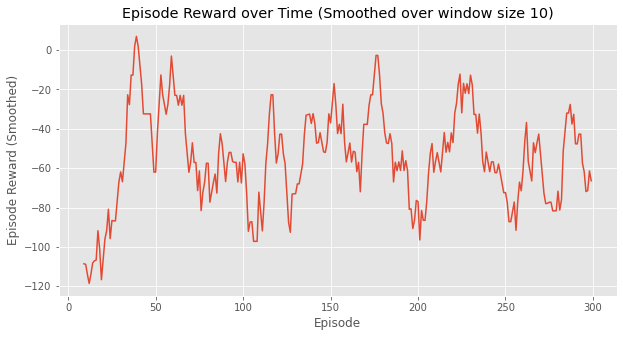

In [18]:
matplotlib.style.use('ggplot')
agent = Agent()
initial_state, time_steps,passengers = stimulated_data() 

no_of_runs = 1
for _ in range(no_of_runs):
  stats = agent.train(initial_state, max_timesteps = time_steps, num_episodes = 300, 
                                 alpha = 0.7, discount = 0.8, epsilon = 0.3,miss_trip_prob = 0.4) 
  satisfied_passengers,cost = agent.solve(initial_state, max_timesteps = time_steps)

  print("\n-----------------------------------------------------------------------")
  print(" Total Passengers : " , passengers)
  print(" Satisfied Passengers :  ", satisfied_passengers)
  print(" Cost :  ", cost)
  print("-----------------------------------------------------------------------\n")
  plot_episode_stats(stats)

#Main using actual flight data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


------------------------ ------------ ------------------------
City AMD:
 Passenger: 2 Origin: AMD Location: AMD Destination: BOM
City AKD:
City IXU:
City BOM:
City PAB:
 Vehicle Number: 3 Location: PAB
City BHJ:
 Passenger: 4 Origin: BHJ Location: BHJ Destination: BOM
 Vehicle Number: 4 Location: BHJ
------------------------ ------------ ------------------------

-----------------------------------------------------------------------
 Total Passengers :  4
 Satisfied Passengers :   0
 Cost :   7.668568112861408
-----------------------------------------------------------------------



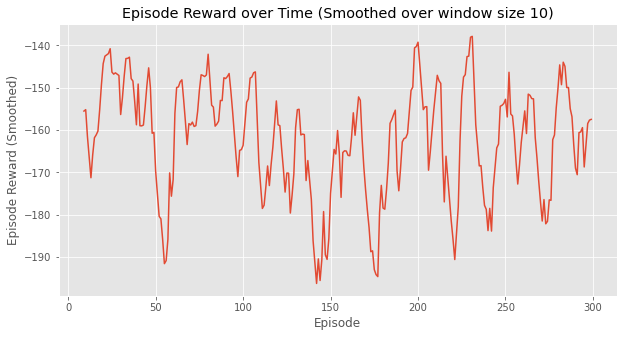

In [30]:
matplotlib.style.use('ggplot')
agent = Agent()
initial_state, time_steps, passengers = data() 

no_of_runs = 1
for _ in range(no_of_runs):
  stats = agent.train(initial_state, max_timesteps = time_steps, num_episodes = 300, 
                                 alpha = 0.7, discount = 0.8, epsilon = 0.3,miss_trip_prob = 0.40)
  satisfied_passengers,cost = agent.solve(initial_state, max_timesteps = time_steps)

  
  print("\n-----------------------------------------------------------------------")
  print(" Total Passengers : " , passengers)
  print(" Satisfied Passengers :  ", satisfied_passengers)
  print(" Cost :  ", cost)
  print("-----------------------------------------------------------------------\n")
  plot_episode_stats(stats)